# Initial setup

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### TODO : please modify the line below with your drive organization ###
path = os.path.join(os.getcwd(), "drive", "MyDrive", "Classes", "Spring 23", "Can of Things")

In [ ]:
path = os.path.join(os.getcwd(), "drive", "MyDrive", "Can of Things")

In [ ]:
import torch
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

vgg_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
train_dir = os.path.join(path, '6cat_augmented', 'train')
test_dir = os.path.join(path, '6cat_augmented', 'test')
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [ ]:
#defining classes

classes=["cardboard", "glass", "metal", "paper", "plastic", "trash"]
classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

## Initial plotting

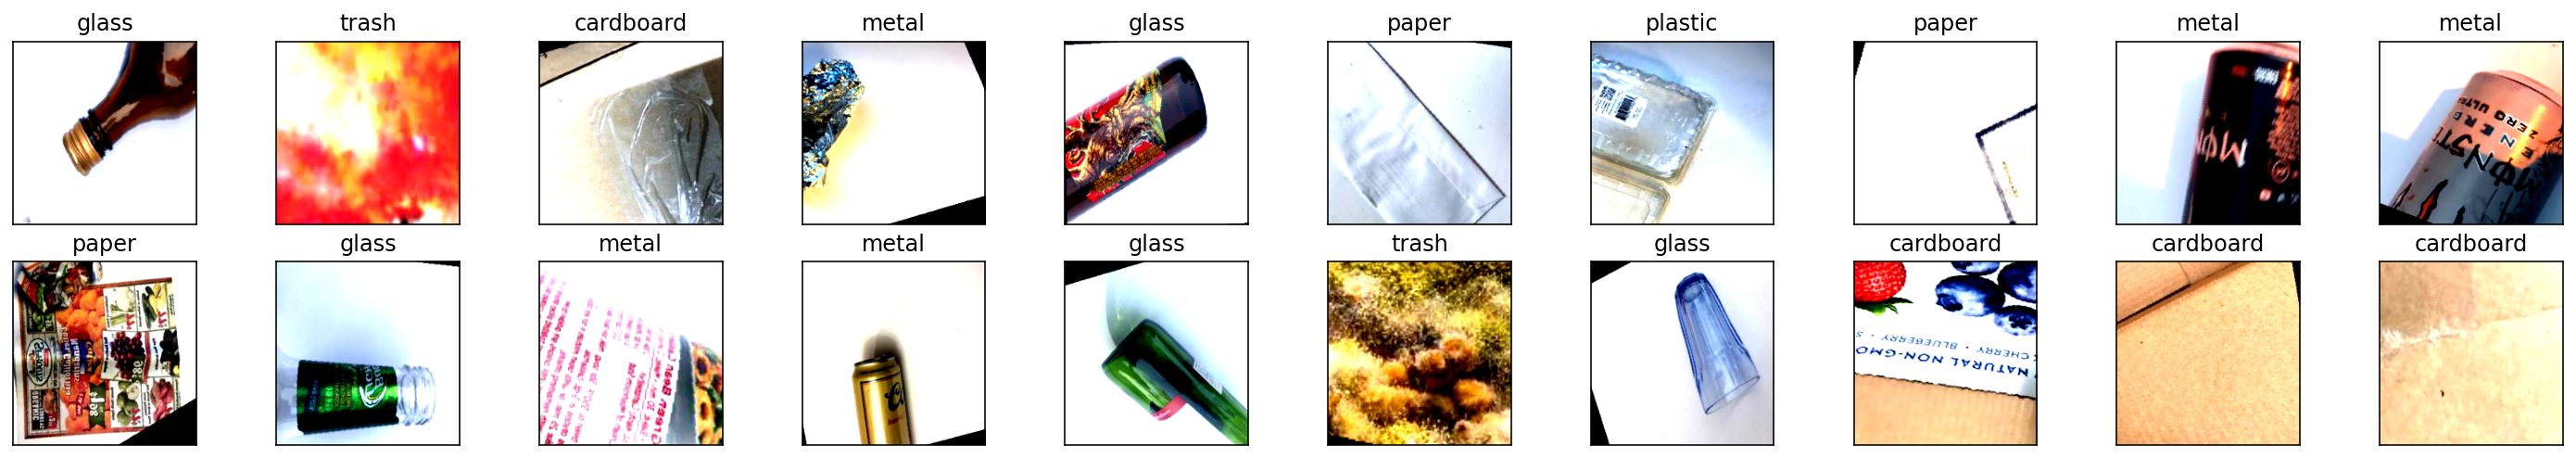

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Model

In [ ]:
model_path = os.path.join(path, 'vgg16_aug_model.pt')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16_bn(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_binary = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
for param in model_binary.parameters():
    param.requires_grad = False
    
model_binary.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model_binary.classifier.parameters(), lr=0.003)

model_binary.to(device);

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

## Classifier

In [ ]:
from torch.optim import lr_scheduler

num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 6 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

# class_weights = torch.tensor([0.84, 0.8, 0.838, 0.76, 0.81, 0.95]).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Training

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), model_path)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.705932 	Validation Loss: 0.541982
Validation loss decreased (inf --> 0.541982).  Saving model ...
Epoch: 2 	Training Loss: 0.607270 	Validation Loss: 0.557226
Epoch: 3 	Training Loss: 0.605508 	Validation Loss: 0.518640
Validation loss decreased (0.541982 --> 0.518640).  Saving model ...
Epoch: 4 	Training Loss: 0.629327 	Validation Loss: 0.513711
Validation loss decreased (0.518640 --> 0.513711).  Saving model ...
Epoch: 5 	Training Loss: 0.594481 	Validation Loss: 0.495491
Validation loss decreased (0.513711 --> 0.495491).  Saving model ...
Epoch: 6 	Training Loss: 0.607417 	Validation Loss: 0.480388
Validation loss decreased (0.495491 --> 0.480388).  Saving model ...
Epoch: 7 	Training Loss: 0.614255 	Validation Loss: 0.525445
Epoch: 8 	Training Loss: 0.584860 	Validation Loss: 0.527744
Epoch: 9 	Training Loss: 0.591920 	Validation Loss: 0.509154
Epoch: 10 	Training Loss: 0.621002 	Validation Loss: 0.540381
Epoch: 11 	Training Loss: 0.579086 	Validation Lo

KeyboardInterrupt: ignored

# Testing

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
model_binary_path = os.path.join(path, "model_waste.pt")
model_binary.load_state_dict(torch.load(model_binary_path))

<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    output = nn.LogSoftmax(dim=1)(output)
    output[:, 5] += 3
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # Do binary model
    binary_output = model_binary(data)
    _, pred_binary = torch.max(binary_output, 1)
    # Compare
    binary_np = 5*(1 - pred_binary.cpu().numpy()).astype(int)
    multi_np = pred.cpu().numpy().astype(int)
    combined = np.maximum(binary_np, multi_np)
    # Combine the two tensors
    combined_output = torch.tensor(combined).to(device)
    # If it's a 0 in binary_output or a 5 in multiclass_output, set it to 5
    # combined_output[combined_output == 0] = 5
    # combined_output[combined_output == 5] = 5
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.559607

Test Accuracy of cardboard: 88% (76/86)
Test Accuracy of glass: 79% (86/108)
Test Accuracy of metal: 70% (58/82)
Test Accuracy of paper: 71% (84/118)
Test Accuracy of plastic: 86% (85/98)
Test Accuracy of trash: 95% (40/42)

Test Accuracy (Overall): 80% (429/534)


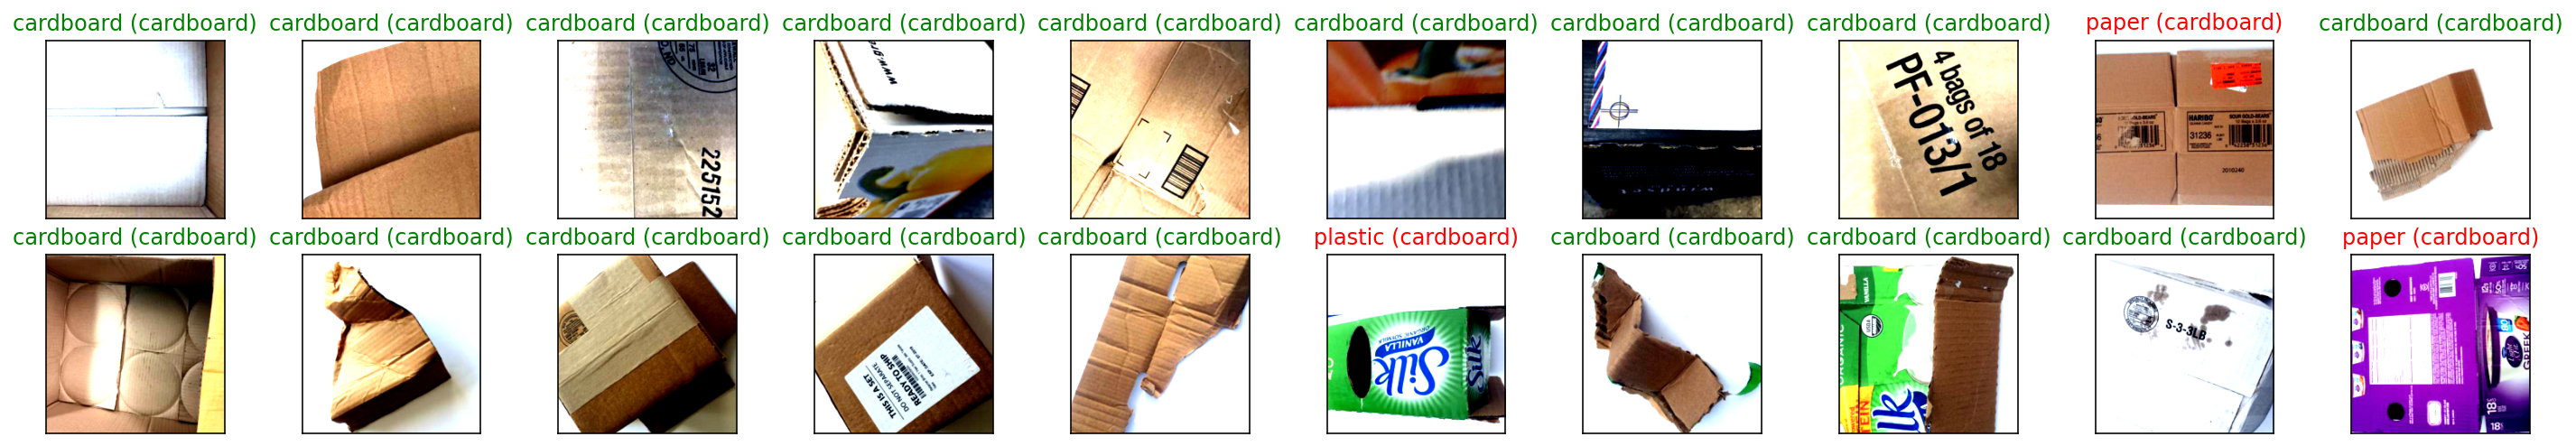

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
# for i in range(15):
#   next(dataiter)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
from PIL import Image

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = test_transforms(image).float()
    image = image.unsqueeze(0) 
    return image.cuda()

def image_loader_v2(image):
    color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(color_coverted)
    image = test_transforms(image).float()
    image = image.unsqueeze(0)
    return image.cuda()

In [ ]:
%%time

our_img_path = os.path.join(path, 'IMG_8193.jpg')

image = image_loader(our_img_path)
model.eval()
output = model(image)
output = nn.ReLU()(output)
output = nn.LogSoftmax(dim=1)(output)
output[:, 5] += 3
_, pred = torch.max(output, 1)
classes[pred]

CPU times: user 246 ms, sys: 0 ns, total: 246 ms
Wall time: 245 ms


'trash'

# YOLO

In [ ]:
yolo_path = os.path.join(path, 'tiny-yolov3.pt')

In [ ]:
!pip install imageai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(yolo_path)
detector.loadModel()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
import io
import PIL
from base64 import b64decode, b64encode

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
import cv2
import numpy as np

video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    # image, preds = detector.detectObjectsFromImage(input_image=img, 
    #                   custom_objects=None,
    #                   output_type="array",
    #                   minimum_percentage_probability=1,
    #                   display_percentage_probability=False,
    #                   display_object_name=True)
    # for pred in preds:
    #     (x1, y1, x2, y2) = pred['box_points']
    #     bbox_array = cv2.rectangle(bbox_array,(x1,y1),(x2,y2),(255,0,0),2)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    # Extract the foreground
    foreground = img.copy()
    foreground[thresh == 0] = 0

    # Analyze the foreground
    num_foreground_pixels = cv2.countNonZero(thresh)
    area_foreground = num_foreground_pixels / (img.shape[0] * img.shape[1])
    centroid_x, centroid_y = cv2.moments(thresh, True)['m10'] / cv2.moments(thresh, True)['m00'], cv2.moments(thresh, True)['m01'] / cv2.moments(thresh, True)['m00']

    # Determine whether there is an object in the foreground
    if num_foreground_pixels > 10000:
      image = image_loader_v2(img)
      model.eval()
      output = model(image)
      output = nn.ReLU()(output)
      output = nn.LogSoftmax(dim=1)(output)
      output[:, 5] += 3
      _, pred = torch.max(output, 1)
      print(classes[pred])
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

paper
trash
trash
trash
paper
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
trash
plastic
plastic
trash
trash
plastic
plastic
plastic
trash
trash
trash
trash
plastic
plastic
plastic
plastic
plastic
plastic
plastic
plastic
paper
paper
paper
paper
trash
paper
paper
paper
paper
paper
paper
paper
paper
paper
trash
trash
paper
paper
trash
paper
paper
paper
trash
paper
paper
paper
paper
paper
paper
paper
paper
paper
paper
trash
paper
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash
trash


KeyboardInterrupt: ignored

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

# YOLO Local

In [ ]:
yolo_path = os.path.join(path, 'tiny-yolov3.pt')

In [ ]:
from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath(yolo_path)
detector.loadModel()

In [ ]:
import cv2
cam = cv2.VideoCapture(0) #0=front-cam, 1=back-cam
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1300)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1500)

In [ ]:
while True:
    ## read frames
    ret, img = cam.read()
    ## predict yolo
    image, preds = detector.detectObjectsFromImage(input_image=img, 
                      custom_objects=None,
                      output_type="array",
                      minimum_percentage_probability=1,
                      display_percentage_probability=False,
                      display_object_name=True)
    ## display predictions
    cv2.imshow("", img)
    if len(preds) > 0:
      image = image_loader_v2(img)
      model.eval()
      output = model(image)
      output = nn.ReLU()(output)
      output = nn.LogSoftmax(dim=1)(output)
      output[:, 5] += 3
      _, pred = torch.max(output, 1)
      print(classes[pred])
    ## press q or Esc to quit    
    if (cv2.waitKey(1) & 0xFF == ord("q")) or (cv2.waitKey(1)==27):
        break
## close camera
cam.release()
cv2.destroyAllWindows()

# Send to Arduino
\

In [ ]:
!pip install pyserial

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 10.0 MB/s eta 0:00:00


In [ ]:
import serial
import time

print("sent")
arduino = serial.Serial('/dev/cu.usbmodem14101',9600, timeout=.1)
time.sleep(1)
arduino.write(str(pred).encode())
time.sleep(1)
arduino.close()

sent


SerialException: ignored

In [ ]:
!pwd

/content
